In [29]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

import pandas_datareader.data as web

import datetime as dt
from IPython.display import display, HTML

In [30]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [31]:
# web scrap closing price from 1/1/2016 to the most recent day for every stock
stockNames = ['TXN', 'STM', 'MU', 'ENTG']

def get_stock(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Close']

stocks = []
#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2017, 11, 9))))

[*********************100%***********************]  1 of 1 downloaded

## Data Pre-Processing

We did a windowing since this a time series analysis and windowing can improve the outcome of the model training.

In [32]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,TXN_0,TXN_1,STM_1,MU_1,ENTG_1
Date,,,,,
2017-11-02,-0.083048,-0.260524,-0.216049,-0.152130,-0.750726
2017-11-03,0.087600,-0.083048,-0.228396,-0.196755,-0.002899
2017-11-06,-0.055746,0.087600,0.030865,-0.436106,0.246378
2017-11-07,-0.215017,-0.055746,-0.222222,-0.367140,0.130433
2017-11-08,-0.174062,-0.215017,-0.574075,0.103449,-0.246377


In [33]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 21
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training
Here we used LSTM from the Keras package as our model. Our activation function is relu and optimiser is Adam optimization. The Adam optimization algorithm update network weights iterative based in training data. This gives it an advantage over the classical stochastic gradient.

In [39]:
#define model
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.02)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.03)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=300, batch_size=batch_size, shuffle=False)

D:\Anaconda\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (21, 10)                  600       
_________________________________________________________________
activation_3 (Activation)    (21, 10)                  0         
_________________________________________________________________
dropout_3 (Dropout)          (21, 10)                  0         
_________________________________________________________________
dense_3 (Dense)              (21, 1)                   11        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
315/315 [==============================] - 0s - loss: 0.0736     
Epoch 2/300
315/315 [==============================] - 0s - loss: 0.0373     
Epoch 3/300
315/315 [==============================] - 0s - loss: 0.0324     
Epoch 4/300
315/315 [=====================

315/315 [==============================] - 0s - loss: 0.0315     
Epoch 196/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 197/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 198/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 199/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 200/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 201/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 202/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 203/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 204/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 205/300
315/315 [==============================] - 0s - loss: 0.0315     
Epoch 206/300
315/315 [==============================] - ETA: 0s - loss: 0.044 - 0s - loss: 0.0315     
Epoch 207/300
315/315 [=======

## Training Outcome

In [40]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(10, batch_input_shape=(new_batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.01)))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.05)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

D:\Anaconda\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Training RMSE: 0.0357


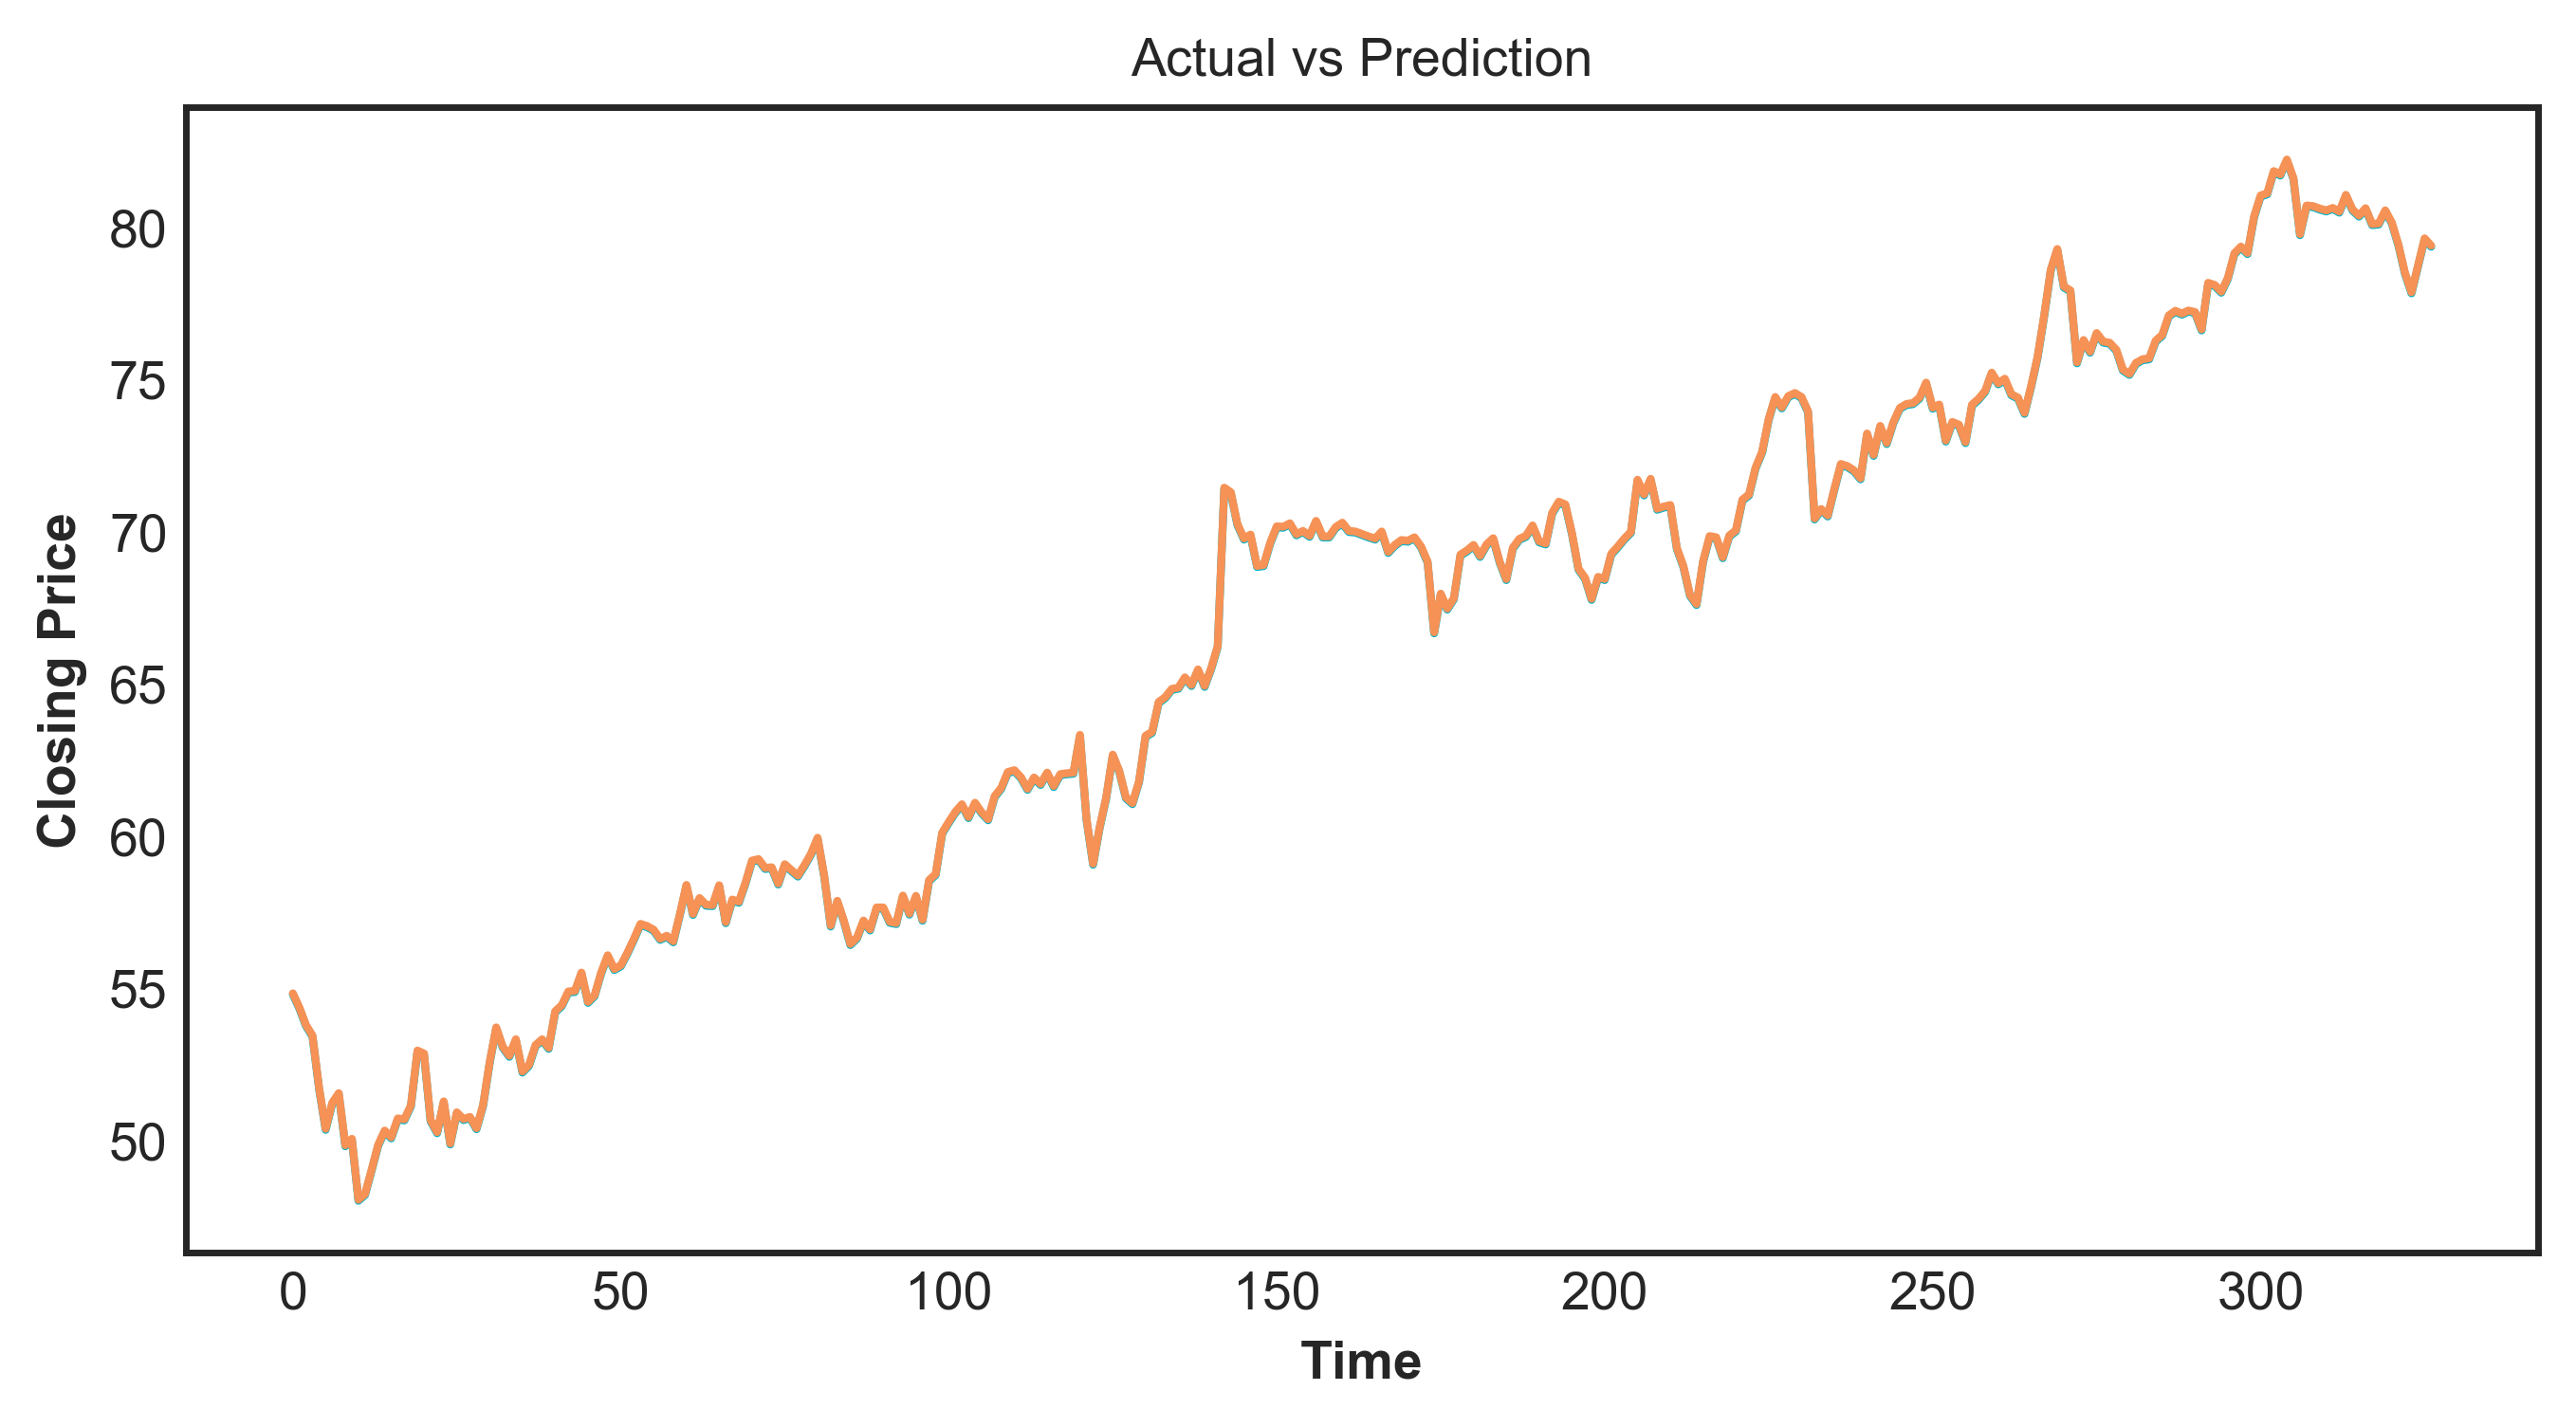

In [41]:
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.4)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [52]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse+' (%.4f' % (rmse/test_predictions[-1][0]*100) +'%)')

Test RMSE: 0.9078 (0.9219%)


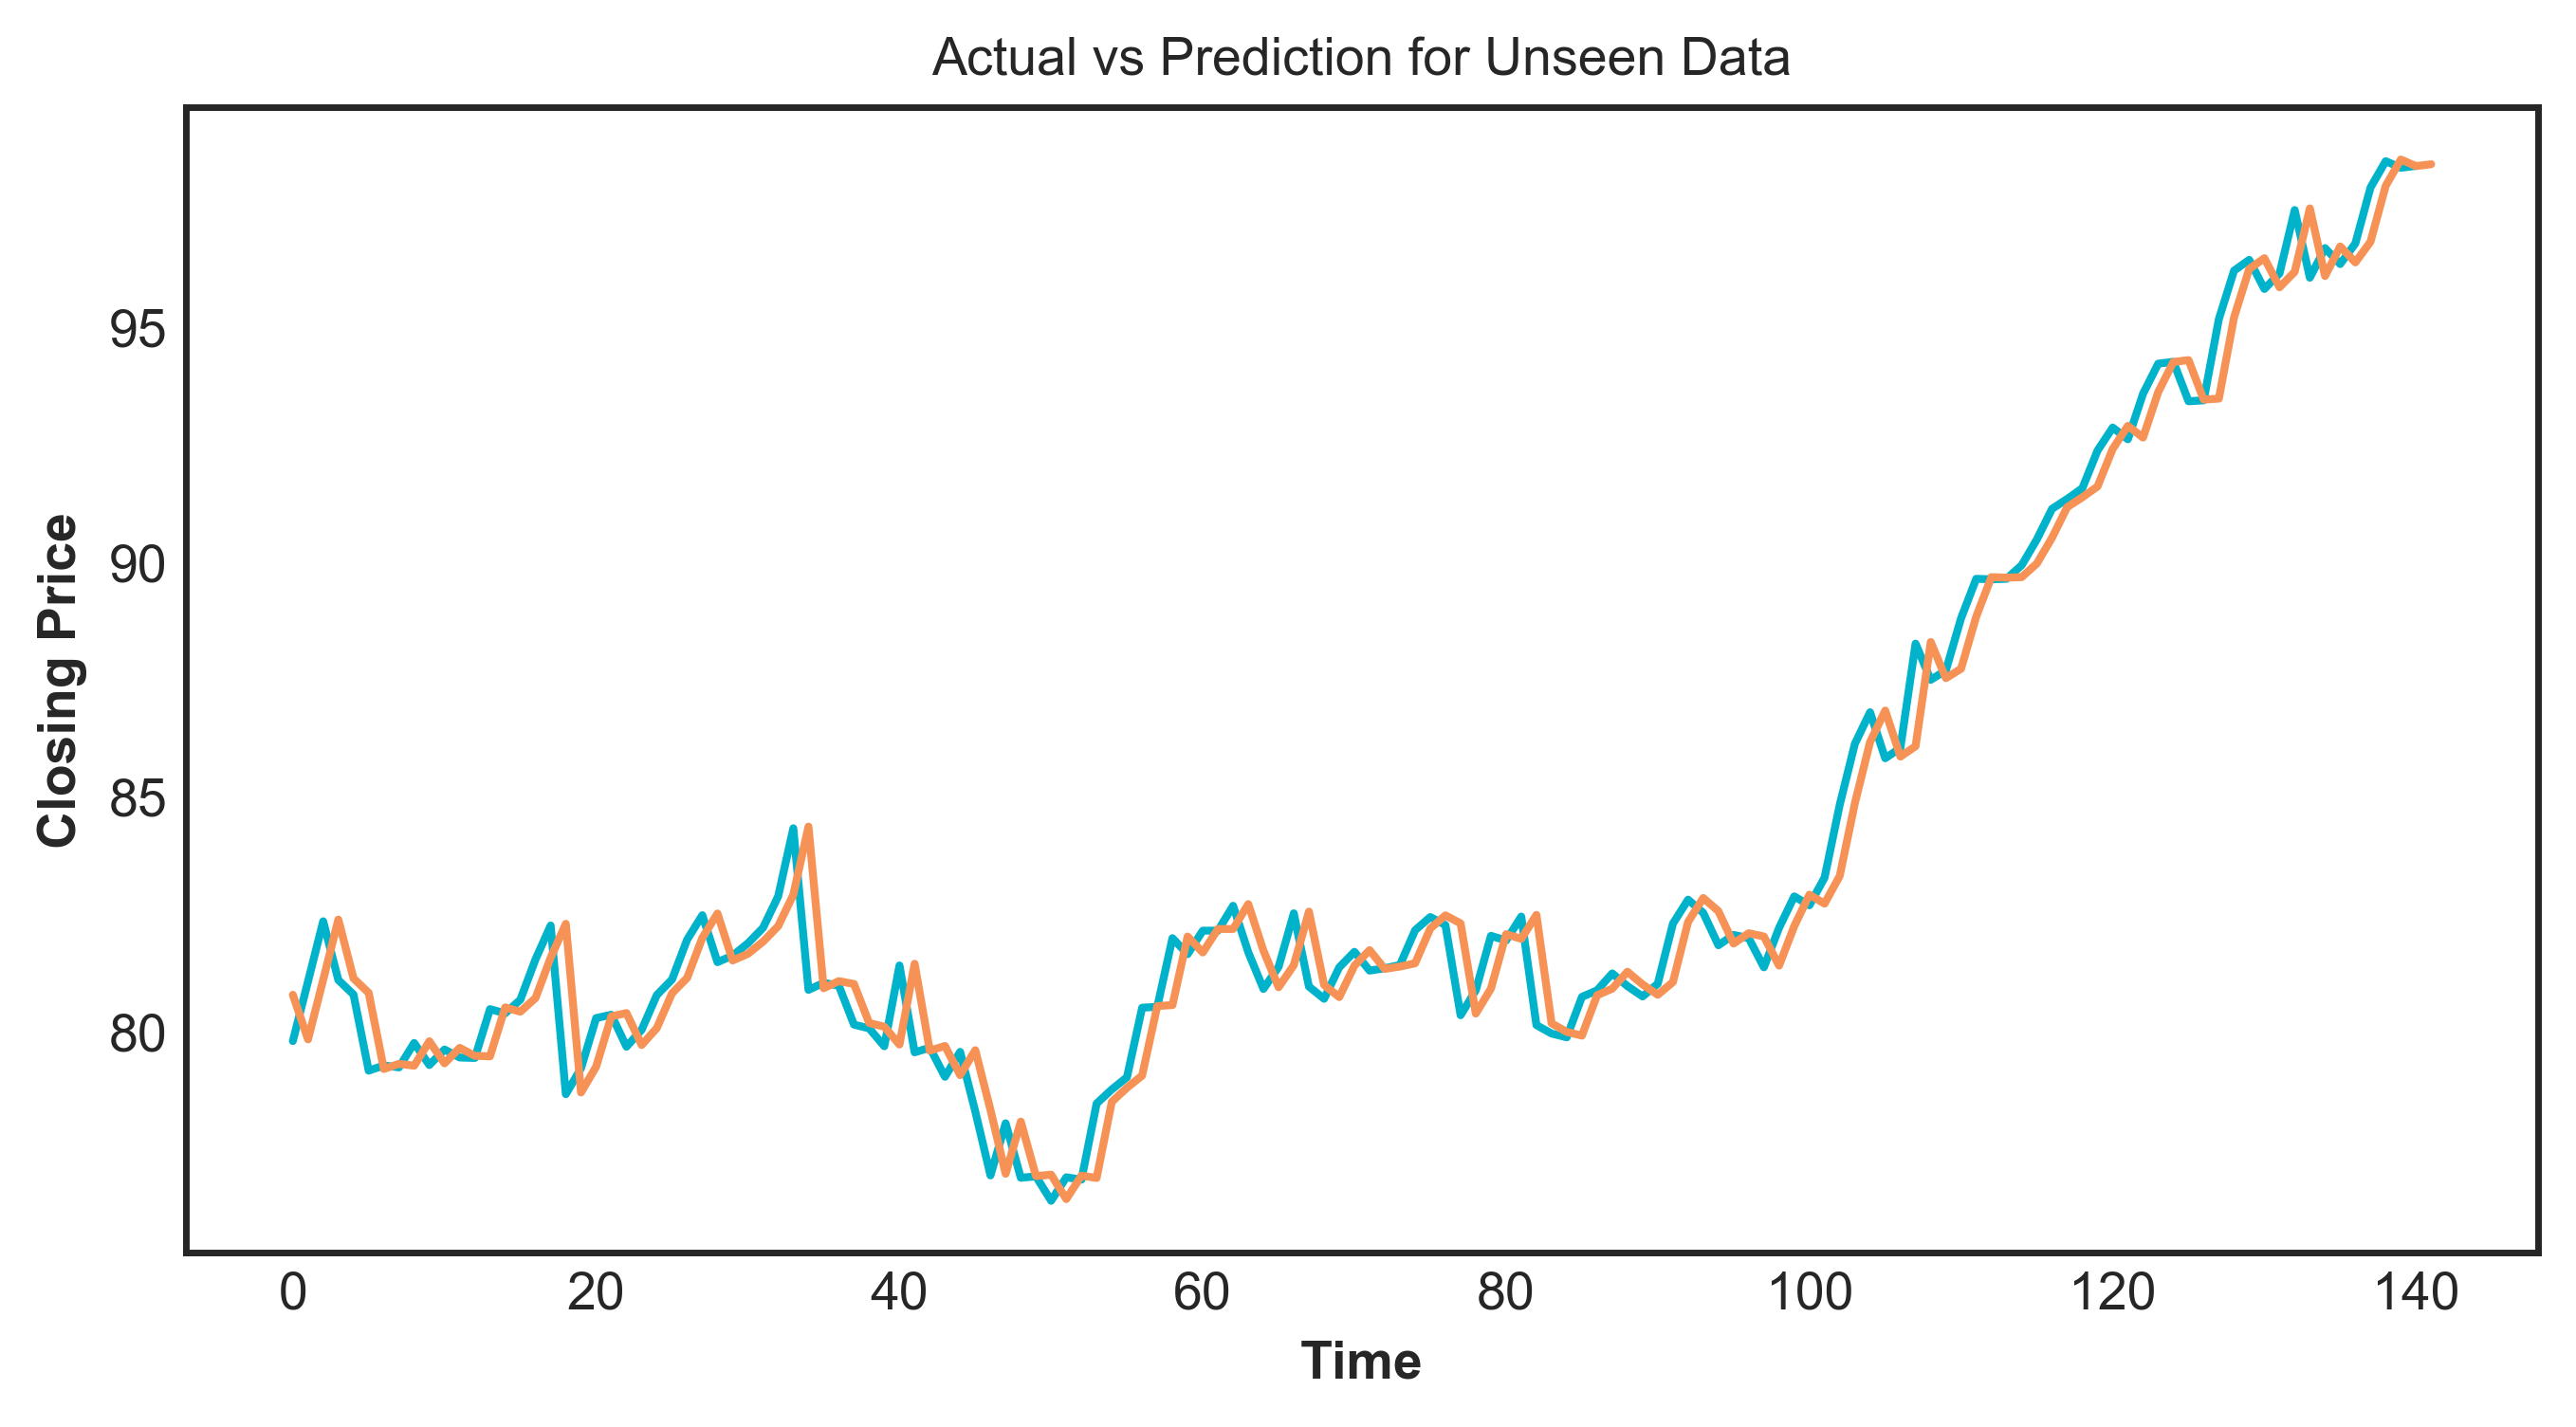

In [43]:
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.4)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price

10/11/2017 is the day we bought the stocks, while 9/11/2017 is the day where we predict a rise in price.

In [44]:
print("Closing Price 9/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 10/11/2017")
print(test_predictions[-1][0])

Closing Price 9/11/2017
98.440002


Predicted Closing Price on 10/11/2017
98.4757
